In [1]:
import pygame, sys, random
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
import math
import matplotlib.pyplot as plt
import pylab

num_episodes = 1000

agentRadius = 10

# get size of state and action from environment

boundaryPos = [400, 590]
boundaryLength = [100, 100]
initPosAgent = [boundaryPos[0] + boundaryLength[0] / 2, boundaryPos[1] + boundaryLength[1] / 2]
goalPos = [boundaryPos[0] + boundaryLength[0], boundaryPos[1]]

moveObstacles = True
action_size = 8
obsNumber = 1
state_size = obsNumber * 2 + 1
# state_size = obsNumber + 1

Using TensorFlow backend.


In [2]:
# A2C(Advantage Actor-Critic) agent
class A2CAgent:
    def __init__(self, state_size, action_size):
        self.load_model = False
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1

        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 0.99
        self.actor_lr = 0.00002
        self.critic_lr = 0.00005

        # create model for policy network
        self.actor = self.build_actor()
        self.critic = self.build_critic()

        if self.load_model:
            self.actor.load_weights("./Practice004_DataSave/Actor.h5")
            self.critic.load_weights("./Practice004_DataSave/Critic.h5")

    # approximate policy and value using Neural Network
    # actor: state is input and probability of each action is output of model
    def build_actor(self):
        actor = Sequential()
        actor.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_normal'))
        actor.add(Dense(self.action_size, activation='softmax', kernel_initializer='glorot_normal'))
        actor.summary()
        # See note regarding crossentropy in cartpole_reinforce.py
        actor.compile(loss='categorical_crossentropy', optimizer=Adam(lr=self.actor_lr))
        return actor

    # critic: state is input and value of state is output of model
    def build_critic(self):
        critic = Sequential()
        critic.add(Dense(128, input_dim=self.state_size, activation='relu', kernel_initializer='glorot_normal'))
        critic.add(Dense(self.value_size, activation='linear', kernel_initializer='glorot_normal'))
        critic.summary()
        critic.compile(loss="mse", optimizer=Adam(lr=self.critic_lr))
        return critic

    # using the output of policy network, pick action stochastically
    def get_action(self, state):
        policy = self.actor.predict(state, batch_size=1).flatten()
#         print policy
        return np.random.choice(self.action_size, 1, p=policy)[0]

    # update policy network every episode
    def train_model(self, state, action, reward, next_state, done):
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))

        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]

        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
        else:
            advantages[0][action] = reward + self.discount_factor * (next_value) - value
            target[0][0] = reward + self.discount_factor * next_value

        self.actor.fit(state, advantages, epochs=1, verbose=0)
        self.critic.fit(state, target, epochs=1, verbose=0)

In [3]:
def ckWall(xPos, yPos):
    flagWall = 0
    if(xPos < boundaryPos[0]):
        xPos = boundaryPos[0]
        flagWall = -1
    elif(xPos > boundaryPos[0] + boundaryLength[0]):
        xPos = boundaryPos[0] + boundaryLength[0]
        flagWall = -1
    if(yPos < boundaryPos[1]):
        yPos = boundaryPos[1]
        flagWall = -1
    elif(yPos > boundaryPos[1] + boundaryLength[1]):
        yPos = boundaryPos[1] + boundaryLength[1]
        flagWall = -1
        
    return [xPos, yPos, flagWall]

In [8]:
def ckInit(initLoc, obsLoc):
    if math.sqrt((initLoc[0] - obsLoc[0])**2 + (initLoc[1] - obsLoc[1])**2) <= 2*agentRadius + 1:
        if initLoc[0] - obsLoc[0] < 0:
            obsLoc[0] += 1
        else:
            obsLoc[0] -= 1
        if initLoc[1] - obsLoc[1] < 0:
            obsLoc[1] += 1
        else:
            obsLoc[1] -= 1
    if math.sqrt((goalPos[0] - obsLoc[0])**2 + (goalPos[1] - obsLoc[1])**2) <= 2*agentRadius + 1:
        obsLoc[0] -= 1
        obsLoc[1] += 1
    return obsLoc

In [5]:
def stateGenerator(obsPosition, agtPosition):
    returnSum = []
    for i in range(0,obsNumber):
#         returnSum = returnSum + [math.sqrt((agtPosition[0] - obsPosition[i][0])**2 + (agtPosition[1] - obsPosition[i][1])**2)]
        returnSum = returnSum + [agtPosition[0] - obsPosition[i][0], agtPosition[1] - obsPosition[i][1]]
#     returnSum = returnSum + [agtPosition[0] - 640, agtPosition[1] - 450]
    returnSum = returnSum + [math.sqrt((agtPosition[0] - goalPos[0])**2 + (agtPosition[1] - goalPos[1])**2)]
    returnSum = np.reshape(returnSum, [1, state_size])
    return returnSum

In [6]:
def takeAction(action):
    xAction = 0
    yAction = 0
    if action == 0:
        xAction = 1
    elif action == 1:
        xAction = 1
        yAction = 1
    elif action == 2:
        xAction = 1
        yAction = -1            
    elif action == 3:
        xAction = -1
        yAction = 1
    elif action == 4:
        xAction = -1
    elif action == 5:
        xAction = -1
        yAction = -1
    elif action == 6:
        yAction = -1
    elif action == 7:
        yAction = 1
        
    return [xAction, yAction]

In [10]:
pygame.init()
screen = pygame.display.set_mode([1280,960])
screen.fill([200, 200, 200])

# make A2C agent
agent = A2CAgent(state_size, action_size)

rList, episodes = [], []

# Make Obstacles (obsNumber)
obstaclePos = [[0, 0] for _ in range(obsNumber)]
for i in range(0,obsNumber):
    while True:
        obstaclePos[i][0] = boundaryPos[0] + random.randrange(1, boundaryLength[0])
        obstaclePos[i][1] = boundaryPos[1] + random.randrange(1, boundaryLength[1])
        if obstaclePos[i][0] <= goalPos[0] - agentRadius or obstaclePos[i][0] >= goalPos[0] + agentRadius:
            if obstaclePos[i][1] >= goalPos[1] + agentRadius or obstaclePos[i][1] <= goalPos[1] - agentRadius:
                if obstaclePos[i][0] <= initPosAgent[0] - agentRadius or obstaclePos[i][0] >= initPosAgent[0] + agentRadius:
                    if obstaclePos[i][1] >= initPosAgent[1] + agentRadius or obstaclePos[i][1] <= initPosAgent[1] - agentRadius:
                        break
                
for e in range(num_episodes):
    # Initialize
    done = False
    score = 0
    x = initPosAgent[0]#boundaryPos[0]
    y = initPosAgent[1]#boundaryPos[1]
    print("Episode ", e, "Starts!")
    state = stateGenerator(obstaclePos, [x,y])
    #state = np.reshape(state, [1, state_size])

    while not done:
        
        action = agent.get_action(state)
        
        xMove = 0
        yMove = 0
        
        [xMove, yMove] = takeAction(action)
        
        x = x + xMove
        y = y + yMove

        wallFlag = 0
        collisionFlag = 0
        [x, y, wallFlag] = ckWall(x,y)
        pygame.draw.circle(screen, [100, 100, 255], [x,y], 10, 0)
#         if wallFlag == -1:
#             print("Wall!", action)
        next_state = stateGenerator(obstaclePos, [x,y])

        if(math.sqrt((x - goalPos[0])**2 + (y - goalPos[1])**2) <= 20):
            print("Goal Reached!")           
            collisionFlag = 1
            done = 1
        for i in range(0,obsNumber):
            if moveObstacles:
                obstaclePos[i][0] = obstaclePos[i][0] + random.randrange(-1,2)
                obstaclePos[i][1] = obstaclePos[i][1] + random.randrange(-1,2)
                [obstaclePos[i][0], obstaclePos[i][1], _] = ckWall(obstaclePos[i][0], obstaclePos[i][1])
                obstaclePos[i] = ckInit(initPosAgent ,obstaclePos[i])

            pygame.draw.circle(screen, [255, 50, 50], obstaclePos[i], 10, 0)
            if math.sqrt((x - obstaclePos[i][0])**2 + (y - obstaclePos[i][1])**2) <= 20:
                print("Collision!")
                collisionFlag = -1
                ObjectIndex = i
                done = True 
#         if wallFlag == -1:
#             done = True
            
        if not done:
            reward = -0.1
            if wallFlag == -1:
                reward = -1
        else:
            if collisionFlag == 1:
                reward = 10000
                rList.append(1)
            elif collisionFlag == -1:
                reward = -10000
                rList.append(0)
#             next_state, reward, done, ininitPosAgentfo = env.step(action)
#             next_state = np.reshape(next_state, [1, state_size])
        # if an action make the episode end, then gives penalty of -100
#             reward = reward if not done or score == 499 else -100
        
        agent.train_model(state, action, reward, next_state, done)

        score += reward
        state = next_state

        if done:
            # every episode, plot the play time

            episodes.append(e)
            pylab.plot(episodes, rList, 'b')
            pylab.savefig("./Practice004_DataSave/ActorCriticGraph.png")
        #circle(Surface, color, pos, radius, width=0)
        pygame.draw.circle(screen, [100,255,100], [goalPos[0],goalPos[1]], 10, 2)
        #rect(Surface, color, Rect, width=0)
        pygame.draw.rect(screen, [255,100,100],[boundaryPos[0] - agentRadius, boundaryPos[1] - agentRadius, boundaryLength[0] + agentRadius * 2, boundaryLength[1] + agentRadius * 2],2)
        pygame.display.flip()
        screen.fill([200,200,200])
    print score
    # save the model
    if e % 50 == 0:
        agent.actor.save_weights("./Practice004_DataSave/Actor.h5")
        agent.critic.save_weights("./Practice004_DataSave/Critic.h5")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               512       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1032      
Total params: 1,544
Trainable params: 1,544
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               512       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________
('Episode ', 0, 'Starts!')
Collision!
-10163.7
('Episode ', 1, 'Starts!')
Co

Goal Reached!
9976.9
('Episode ', 143, 'Starts!')
Goal Reached!
9984.9
('Episode ', 144, 'Starts!')
Goal Reached!
9982.9
('Episode ', 145, 'Starts!')
Goal Reached!
9976.0
('Episode ', 146, 'Starts!')
Goal Reached!
9968.0
('Episode ', 147, 'Starts!')
Goal Reached!
9984.9
('Episode ', 148, 'Starts!')
Goal Reached!
9961.6
('Episode ', 149, 'Starts!')
Goal Reached!
9955.2
('Episode ', 150, 'Starts!')
Collision!
-10966.6
('Episode ', 151, 'Starts!')
Collision!
-11069.0
('Episode ', 152, 'Starts!')
Collision!
-10003.2
('Episode ', 153, 'Starts!')
Collision!
-10002.6
('Episode ', 154, 'Starts!')
Collision!
-10002.9
('Episode ', 155, 'Starts!')
Collision!
-10003.2
('Episode ', 156, 'Starts!')
Collision!
-10003.2
('Episode ', 157, 'Starts!')
Collision!
-10003.4
('Episode ', 158, 'Starts!')
Collision!
-10005.5
('Episode ', 159, 'Starts!')
Collision!
-10007.8
('Episode ', 160, 'Starts!')
Collision!
-10020.2
('Episode ', 161, 'Starts!')
Collision!
-10099.6
('Episode ', 162, 'Starts!')
Collision!
-

Goal Reached!
9996.1
('Episode ', 308, 'Starts!')
Collision!
-10011.1
('Episode ', 309, 'Starts!')
Collision!
-10001.1
('Episode ', 310, 'Starts!')
Collision!
-10002.0
('Episode ', 311, 'Starts!')
Collision!
-10029.3
('Episode ', 312, 'Starts!')
Collision!
-10192.9
('Episode ', 313, 'Starts!')
Collision!
-10088.9
('Episode ', 314, 'Starts!')
Collision!
-10033.9
('Episode ', 315, 'Starts!')
Collision!
-10025.4
('Episode ', 316, 'Starts!')
Collision!
-10817.7
('Episode ', 317, 'Starts!')
Collision!
-10067.4
('Episode ', 318, 'Starts!')
Goal Reached!
9953.6
('Episode ', 319, 'Starts!')
Collision!
-10033.6
('Episode ', 320, 'Starts!')
Goal Reached!
9947.4
('Episode ', 321, 'Starts!')
Goal Reached!
9970.5
('Episode ', 322, 'Starts!')
Goal Reached!
9963.2
('Episode ', 323, 'Starts!')
Goal Reached!
9953.4
('Episode ', 324, 'Starts!')
Goal Reached!
9955.4
('Episode ', 325, 'Starts!')
Goal Reached!
9961.8
('Episode ', 326, 'Starts!')
Goal Reached!
9982.0
('Episode ', 327, 'Starts!')
Goal Reache

9976.0
('Episode ', 472, 'Starts!')
Goal Reached!
9993.8
('Episode ', 473, 'Starts!')
Goal Reached!
9986.0
('Episode ', 474, 'Starts!')
Goal Reached!
9958.0
('Episode ', 475, 'Starts!')
Goal Reached!
9964.0
('Episode ', 476, 'Starts!')
Goal Reached!
9961.8
('Episode ', 477, 'Starts!')
Collision!
-10071.8
('Episode ', 478, 'Starts!')
Goal Reached!
9447.0
('Episode ', 479, 'Starts!')
Goal Reached!
9568.8
('Episode ', 480, 'Starts!')
Goal Reached!
9922.0
('Episode ', 481, 'Starts!')
Goal Reached!
9914.0
('Episode ', 482, 'Starts!')
Goal Reached!
9884.0
('Episode ', 483, 'Starts!')
Goal Reached!
9152.8
('Episode ', 484, 'Starts!')
Goal Reached!
9922.0
('Episode ', 485, 'Starts!')
Collision!
-10785.5
('Episode ', 486, 'Starts!')
Collision!
-10009.6
('Episode ', 487, 'Starts!')
Collision!
-10007.8
('Episode ', 488, 'Starts!')
Collision!
-10261.4
('Episode ', 489, 'Starts!')
Collision!
-10098.7
('Episode ', 490, 'Starts!')
Collision!
-10225.1
('Episode ', 491, 'Starts!')
Collision!
-10346.2
(

9996.4
('Episode ', 637, 'Starts!')
Goal Reached!
9996.5
('Episode ', 638, 'Starts!')
Goal Reached!
9996.5
('Episode ', 639, 'Starts!')
Goal Reached!
9996.5
('Episode ', 640, 'Starts!')
Goal Reached!
9996.5
('Episode ', 641, 'Starts!')
Goal Reached!
9996.5
('Episode ', 642, 'Starts!')
Goal Reached!
9996.5
('Episode ', 643, 'Starts!')
Goal Reached!
9996.5
('Episode ', 644, 'Starts!')
Goal Reached!
9996.5
('Episode ', 645, 'Starts!')
Goal Reached!
9996.5
('Episode ', 646, 'Starts!')
Goal Reached!
9996.5
('Episode ', 647, 'Starts!')
Goal Reached!
9996.5
('Episode ', 648, 'Starts!')
Goal Reached!
9996.5
('Episode ', 649, 'Starts!')
Goal Reached!
9996.5
('Episode ', 650, 'Starts!')
Goal Reached!
9996.5
('Episode ', 651, 'Starts!')
Goal Reached!
9996.5
('Episode ', 652, 'Starts!')
Goal Reached!
9996.5
('Episode ', 653, 'Starts!')
Goal Reached!
9996.5
('Episode ', 654, 'Starts!')
Goal Reached!
9996.5
('Episode ', 655, 'Starts!')
Goal Reached!
9996.5
('Episode ', 656, 'Starts!')
Goal Reached!


9996.5
('Episode ', 801, 'Starts!')
Goal Reached!
9996.5
('Episode ', 802, 'Starts!')
Goal Reached!
9996.5
('Episode ', 803, 'Starts!')
Goal Reached!
9996.5
('Episode ', 804, 'Starts!')
Goal Reached!
9996.5
('Episode ', 805, 'Starts!')
Goal Reached!
9996.5
('Episode ', 806, 'Starts!')
Goal Reached!
9996.5
('Episode ', 807, 'Starts!')
Goal Reached!
9996.5
('Episode ', 808, 'Starts!')
Goal Reached!
9996.5
('Episode ', 809, 'Starts!')
Goal Reached!
9996.5
('Episode ', 810, 'Starts!')
Goal Reached!
9996.5
('Episode ', 811, 'Starts!')
Goal Reached!
9996.5
('Episode ', 812, 'Starts!')
Goal Reached!
9996.5
('Episode ', 813, 'Starts!')
Goal Reached!
9996.5
('Episode ', 814, 'Starts!')
Goal Reached!
9996.5
('Episode ', 815, 'Starts!')
Goal Reached!
9996.5
('Episode ', 816, 'Starts!')
Goal Reached!
9996.5
('Episode ', 817, 'Starts!')
Goal Reached!
9996.5
('Episode ', 818, 'Starts!')
Goal Reached!
9996.5
('Episode ', 819, 'Starts!')
Goal Reached!
9996.5
('Episode ', 820, 'Starts!')
Goal Reached!


9996.5
('Episode ', 965, 'Starts!')
Goal Reached!
9996.5
('Episode ', 966, 'Starts!')
Goal Reached!
9996.5
('Episode ', 967, 'Starts!')
Goal Reached!
9996.5
('Episode ', 968, 'Starts!')
Goal Reached!
9996.5
('Episode ', 969, 'Starts!')
Goal Reached!
9996.5
('Episode ', 970, 'Starts!')
Goal Reached!
9996.5
('Episode ', 971, 'Starts!')
Goal Reached!
9996.5
('Episode ', 972, 'Starts!')
Goal Reached!
9996.5
('Episode ', 973, 'Starts!')
Goal Reached!
9996.5
('Episode ', 974, 'Starts!')
Goal Reached!
9996.5
('Episode ', 975, 'Starts!')
Goal Reached!
9996.5
('Episode ', 976, 'Starts!')
Goal Reached!
9996.5
('Episode ', 977, 'Starts!')
Goal Reached!
9996.5
('Episode ', 978, 'Starts!')
Goal Reached!
9996.5
('Episode ', 979, 'Starts!')
Goal Reached!
9996.5
('Episode ', 980, 'Starts!')
Goal Reached!
9996.5
('Episode ', 981, 'Starts!')
Goal Reached!
9996.5
('Episode ', 982, 'Starts!')
Goal Reached!
9996.5
('Episode ', 983, 'Starts!')
Goal Reached!
9996.5
('Episode ', 984, 'Starts!')
Goal Reached!


Percent of successful episodes: 79.7%


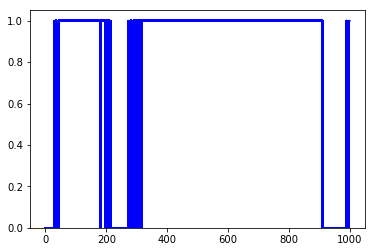

In [9]:
print("Percent of successful episodes: " + str(100.0 * sum(rList)/num_episodes) + "%")

plt.bar(range(len(rList)), rList, color = "Blue", width = 0.00001)
plt.show()